In [213]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from datetime import timedelta

In [166]:
# get ticker information
tickers = yf.Tickers('aapl')
aapl = tickers.tickers.AAPL.history(period="max")[['Close']]

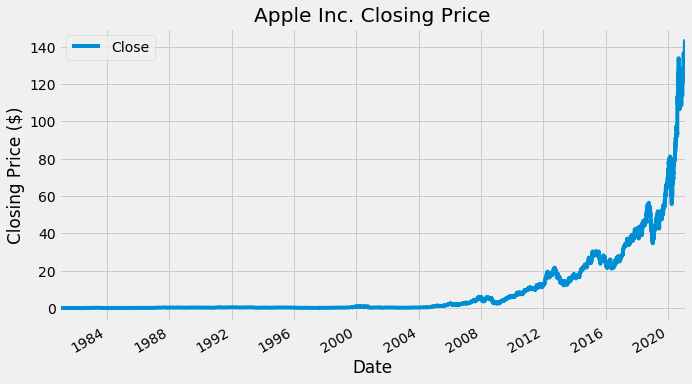

In [167]:
aapl.plot()
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend(loc='upper left')
plt.title('Apple Inc. Closing Price')
plt.show();

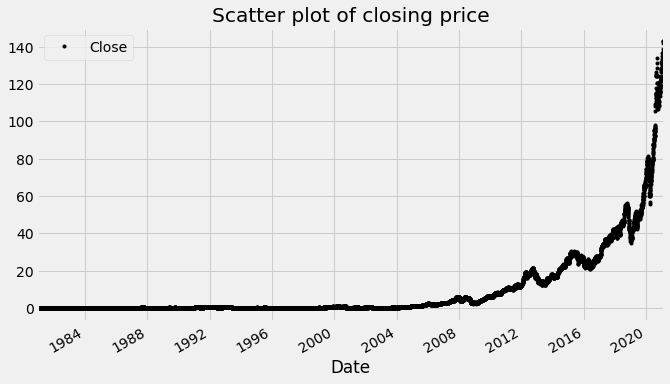

In [168]:
aapl.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.legend(loc='upper left')
plt.show()

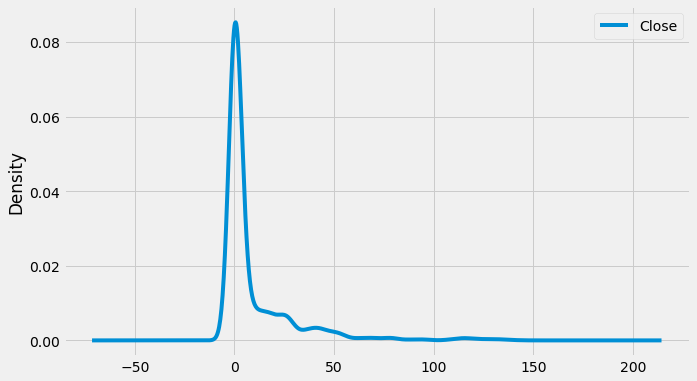

In [169]:
aapl.plot.kde();

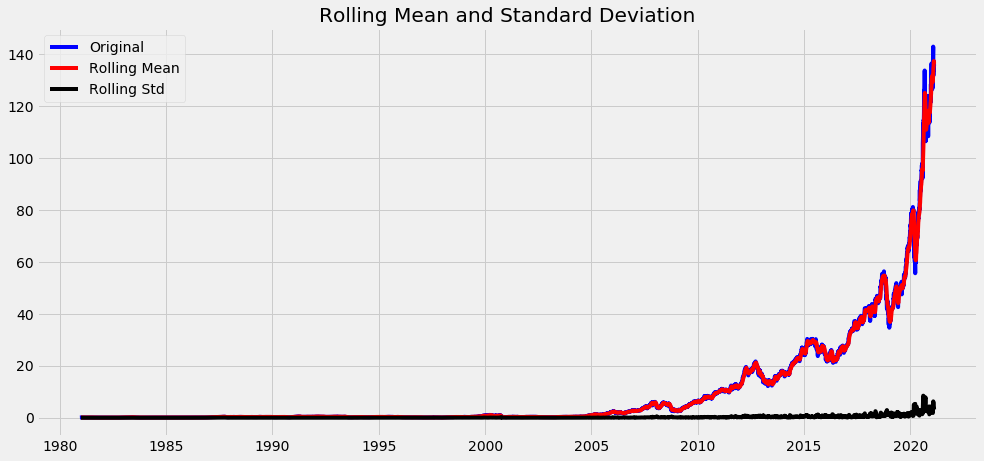

Results of dickey fuller test
Test Statistics                    6.652012
p-value                            1.000000
No. of lags used                  38.000000
Number of observations used    10087.000000
critical value (1%)               -3.430998
critical value (5%)               -2.861827
critical value (10%)              -2.566923
dtype: float64


In [170]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15,7))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries.iloc[:,0].values,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(aapl)

<Figure size 720x432 with 0 Axes>

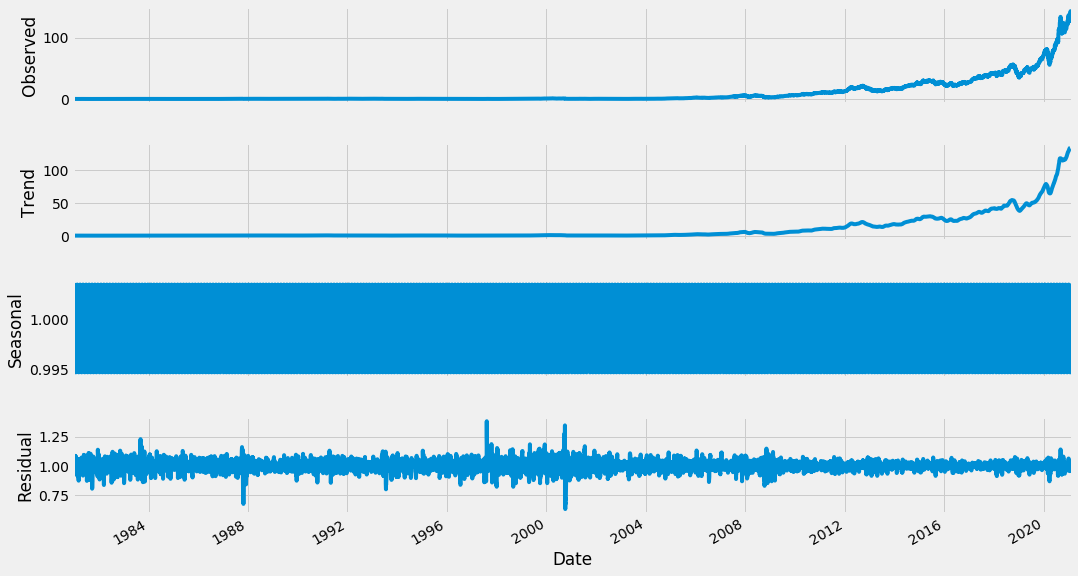

In [171]:
result = seasonal_decompose(aapl, model='multiplicative', freq = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

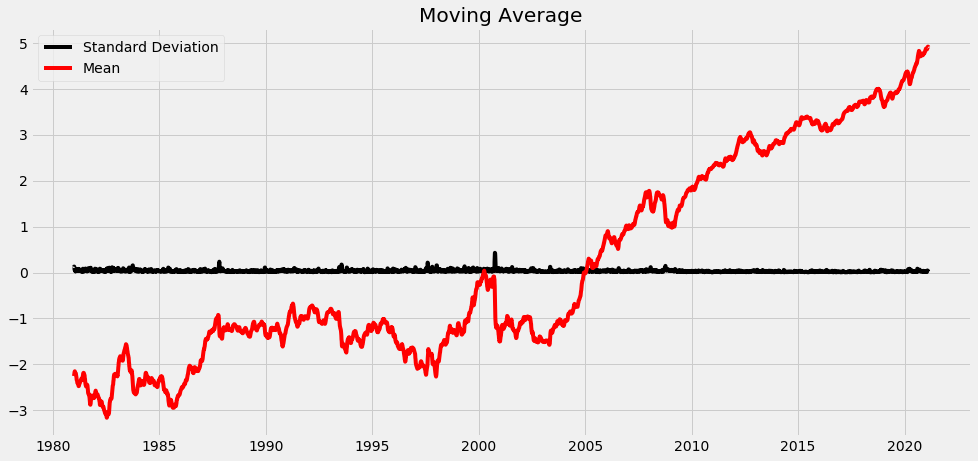

In [172]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df_log = np.log(aapl)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
ax.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

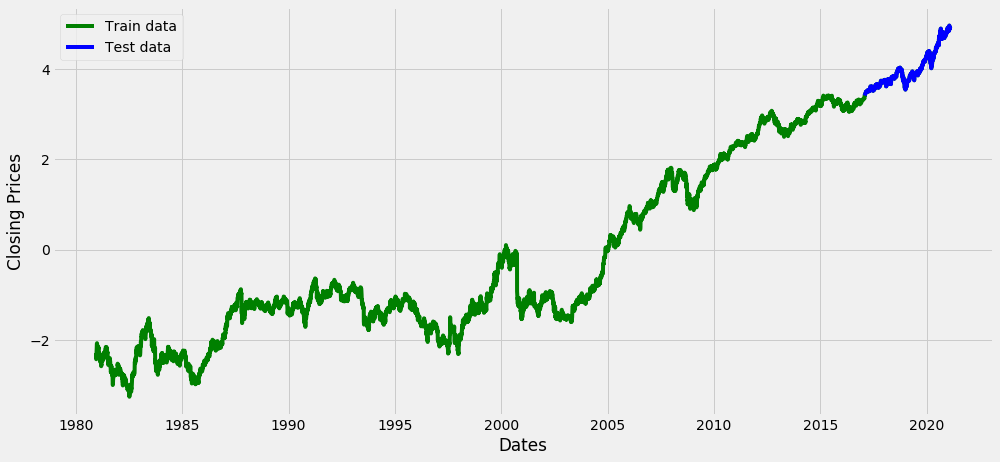

In [173]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(15,7))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend();

In [269]:
smodel = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38091.539, Time=1.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38094.758, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38094.968, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38089.387, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-38091.573, Time=2.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-38096.640, Time=2.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-38094.219, Time=2.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-38103.836, Time=2.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-38107.128, Time=1.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-38105.132, Time=1.89 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-38100.251, Time=6.15 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-38105.059, Time=1.16 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 24.047 seconds
                           Statespace Model Results            

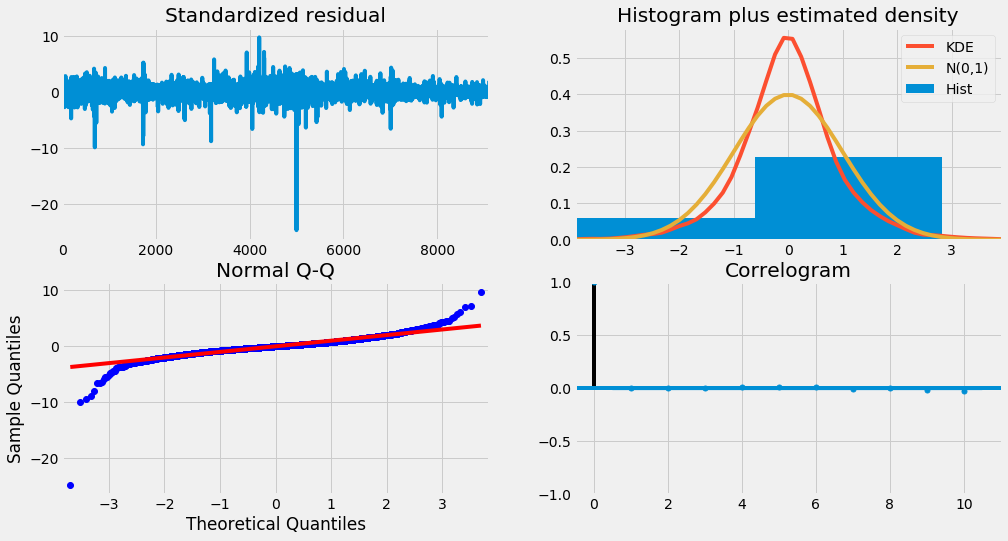

In [270]:
smodel.plot_diagnostics(figsize=(15,8))
plt.show()

In [302]:
model = ARIMA(train_data, order=(0, 1, 3))  
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 9109
Model:                 ARIMA(0, 1, 3)   Log Likelihood               19056.918
Method:                       css-mle   S.D. of innovations              0.030
Date:                Wed, 10 Feb 2021   AIC                         -38103.837
Time:                        17:23:28   BIC                         -38068.252
Sample:                             1   HQIC                        -38091.735
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      2.091      0.037    4.01e-05       0.001
ma.L1.D.Close     0.0256      0.010      2.443      0.015       0.005       0.046
ma.L2.D.Close    -0.0201      0.010     

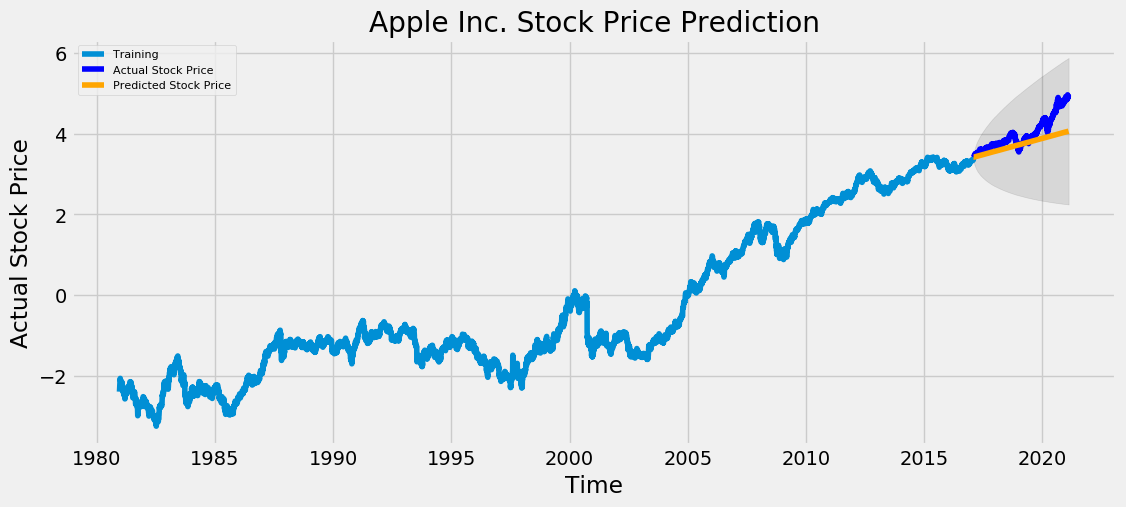

In [303]:
# Forecast
fc, se, conf = fitted.forecast(test_data.shape[0], alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [304]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data.values.reshape(1013,1))/np.abs(test_data.values.reshape(1013,1)))
print('MAPE: '+str(mape))

MSE: 0.1281305875402086
MAE: 0.26758490302601934
RMSE: 0.3579533315115374
MAPE: 0.09005890309794842
